In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import matplotlib

In [3]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account('a4216d8e3d0791f1496a69dd9edcf472a0e7ed7c8ca57fe15b33a9af5fdd1c970bb4d8feff0e2986d4810a3c34fba9ffeda9c07ecdde6e8339a8ad4beaa27ab2')

C:\ProgramData\anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


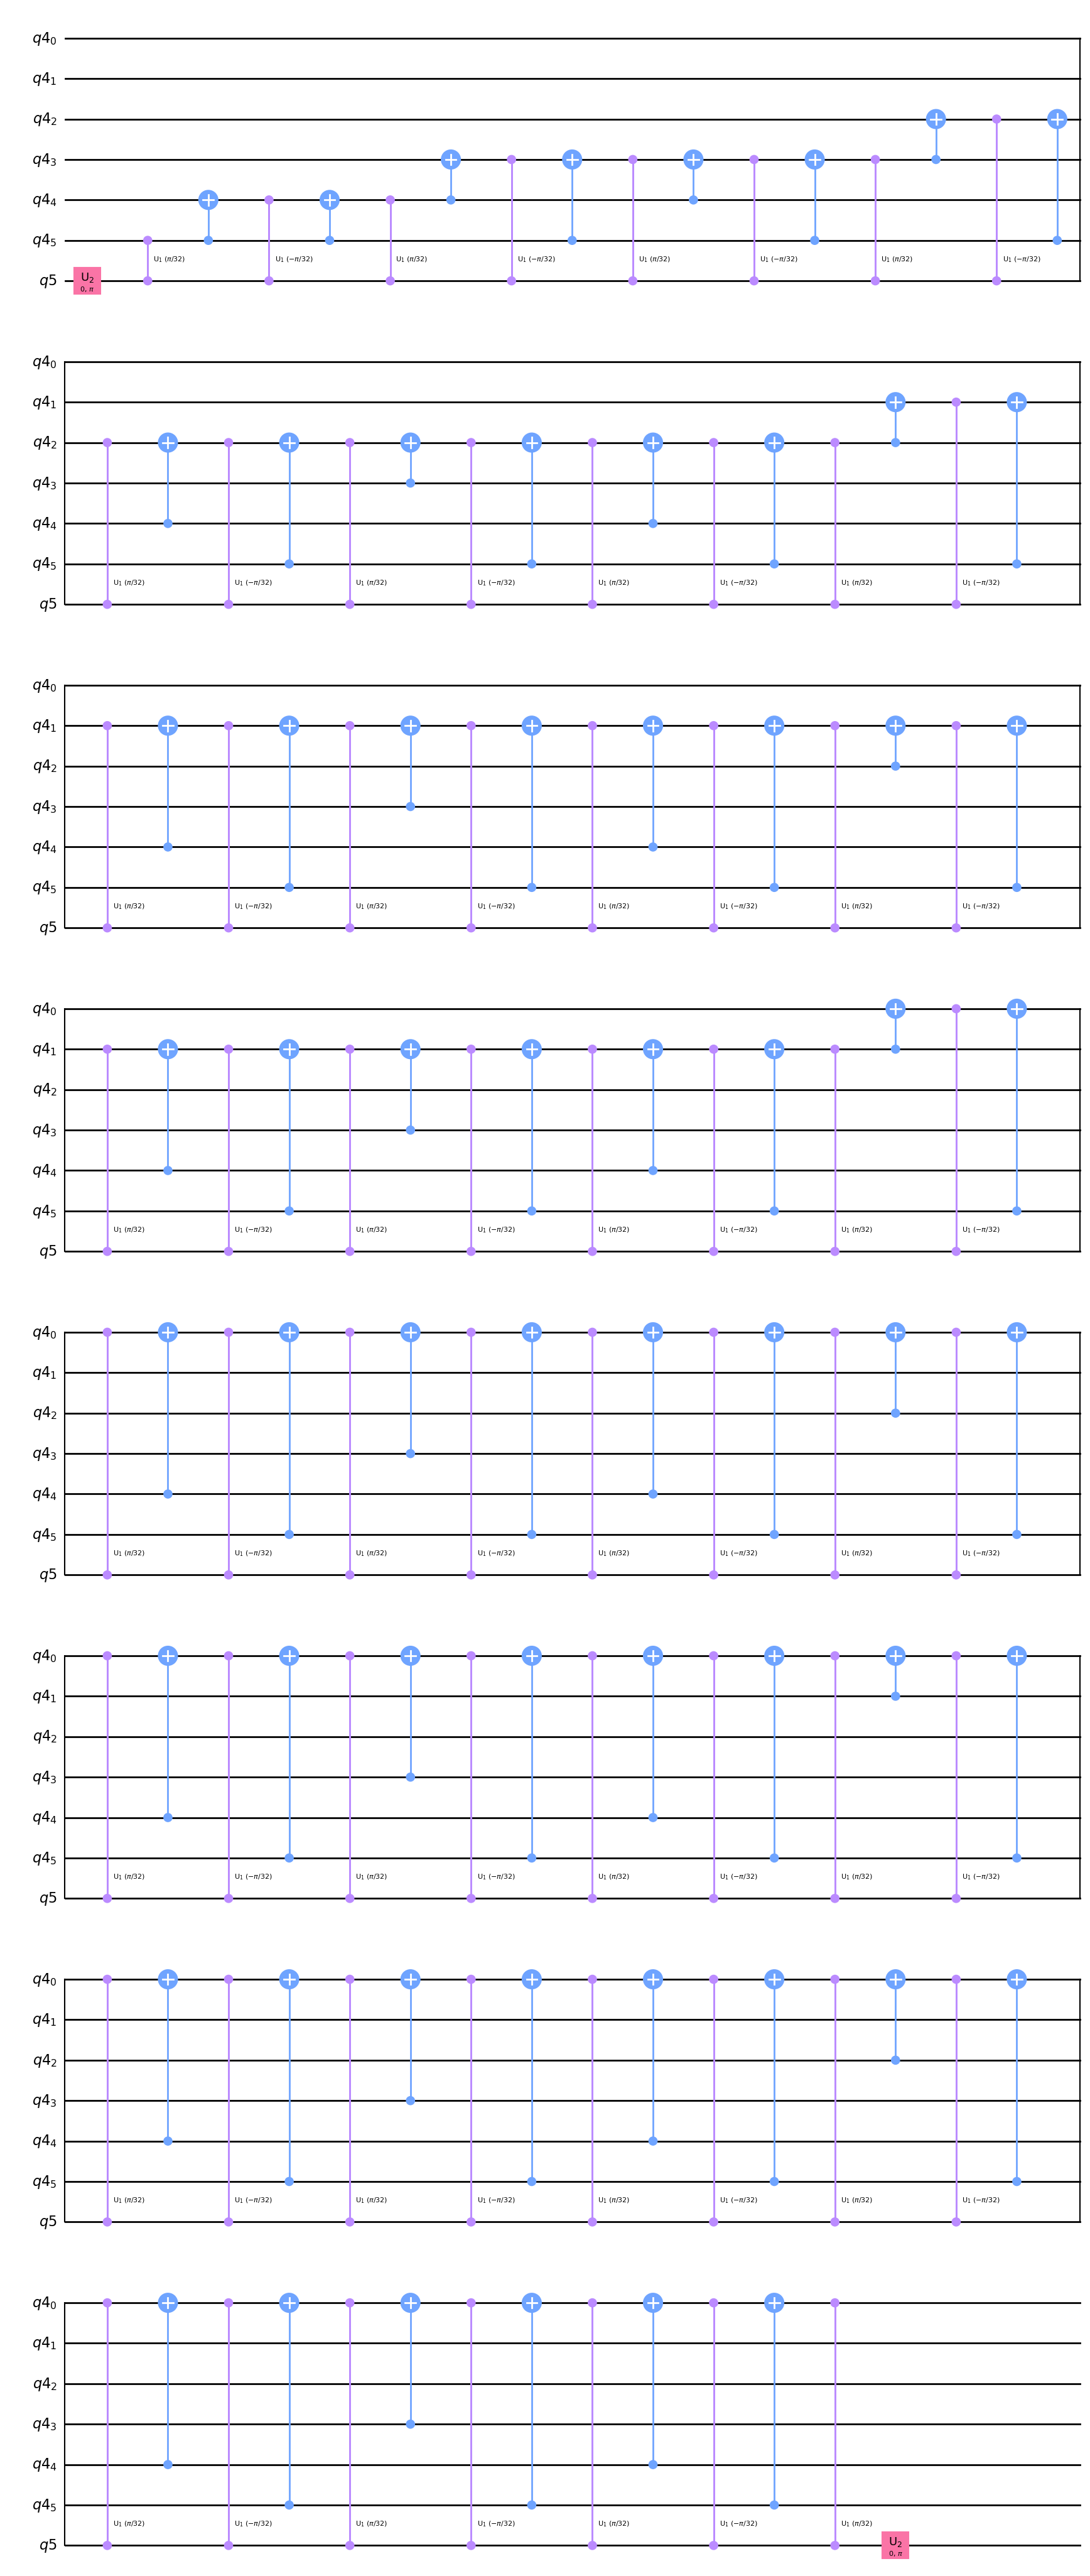

In [4]:
control = QuantumRegister(6)
target = QuantumRegister(1)
qc = QuantumCircuit(control, target)
qc.mcx(control, target[0])
qc.decompose().decompose().draw('mpl')

C:\ProgramData\anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


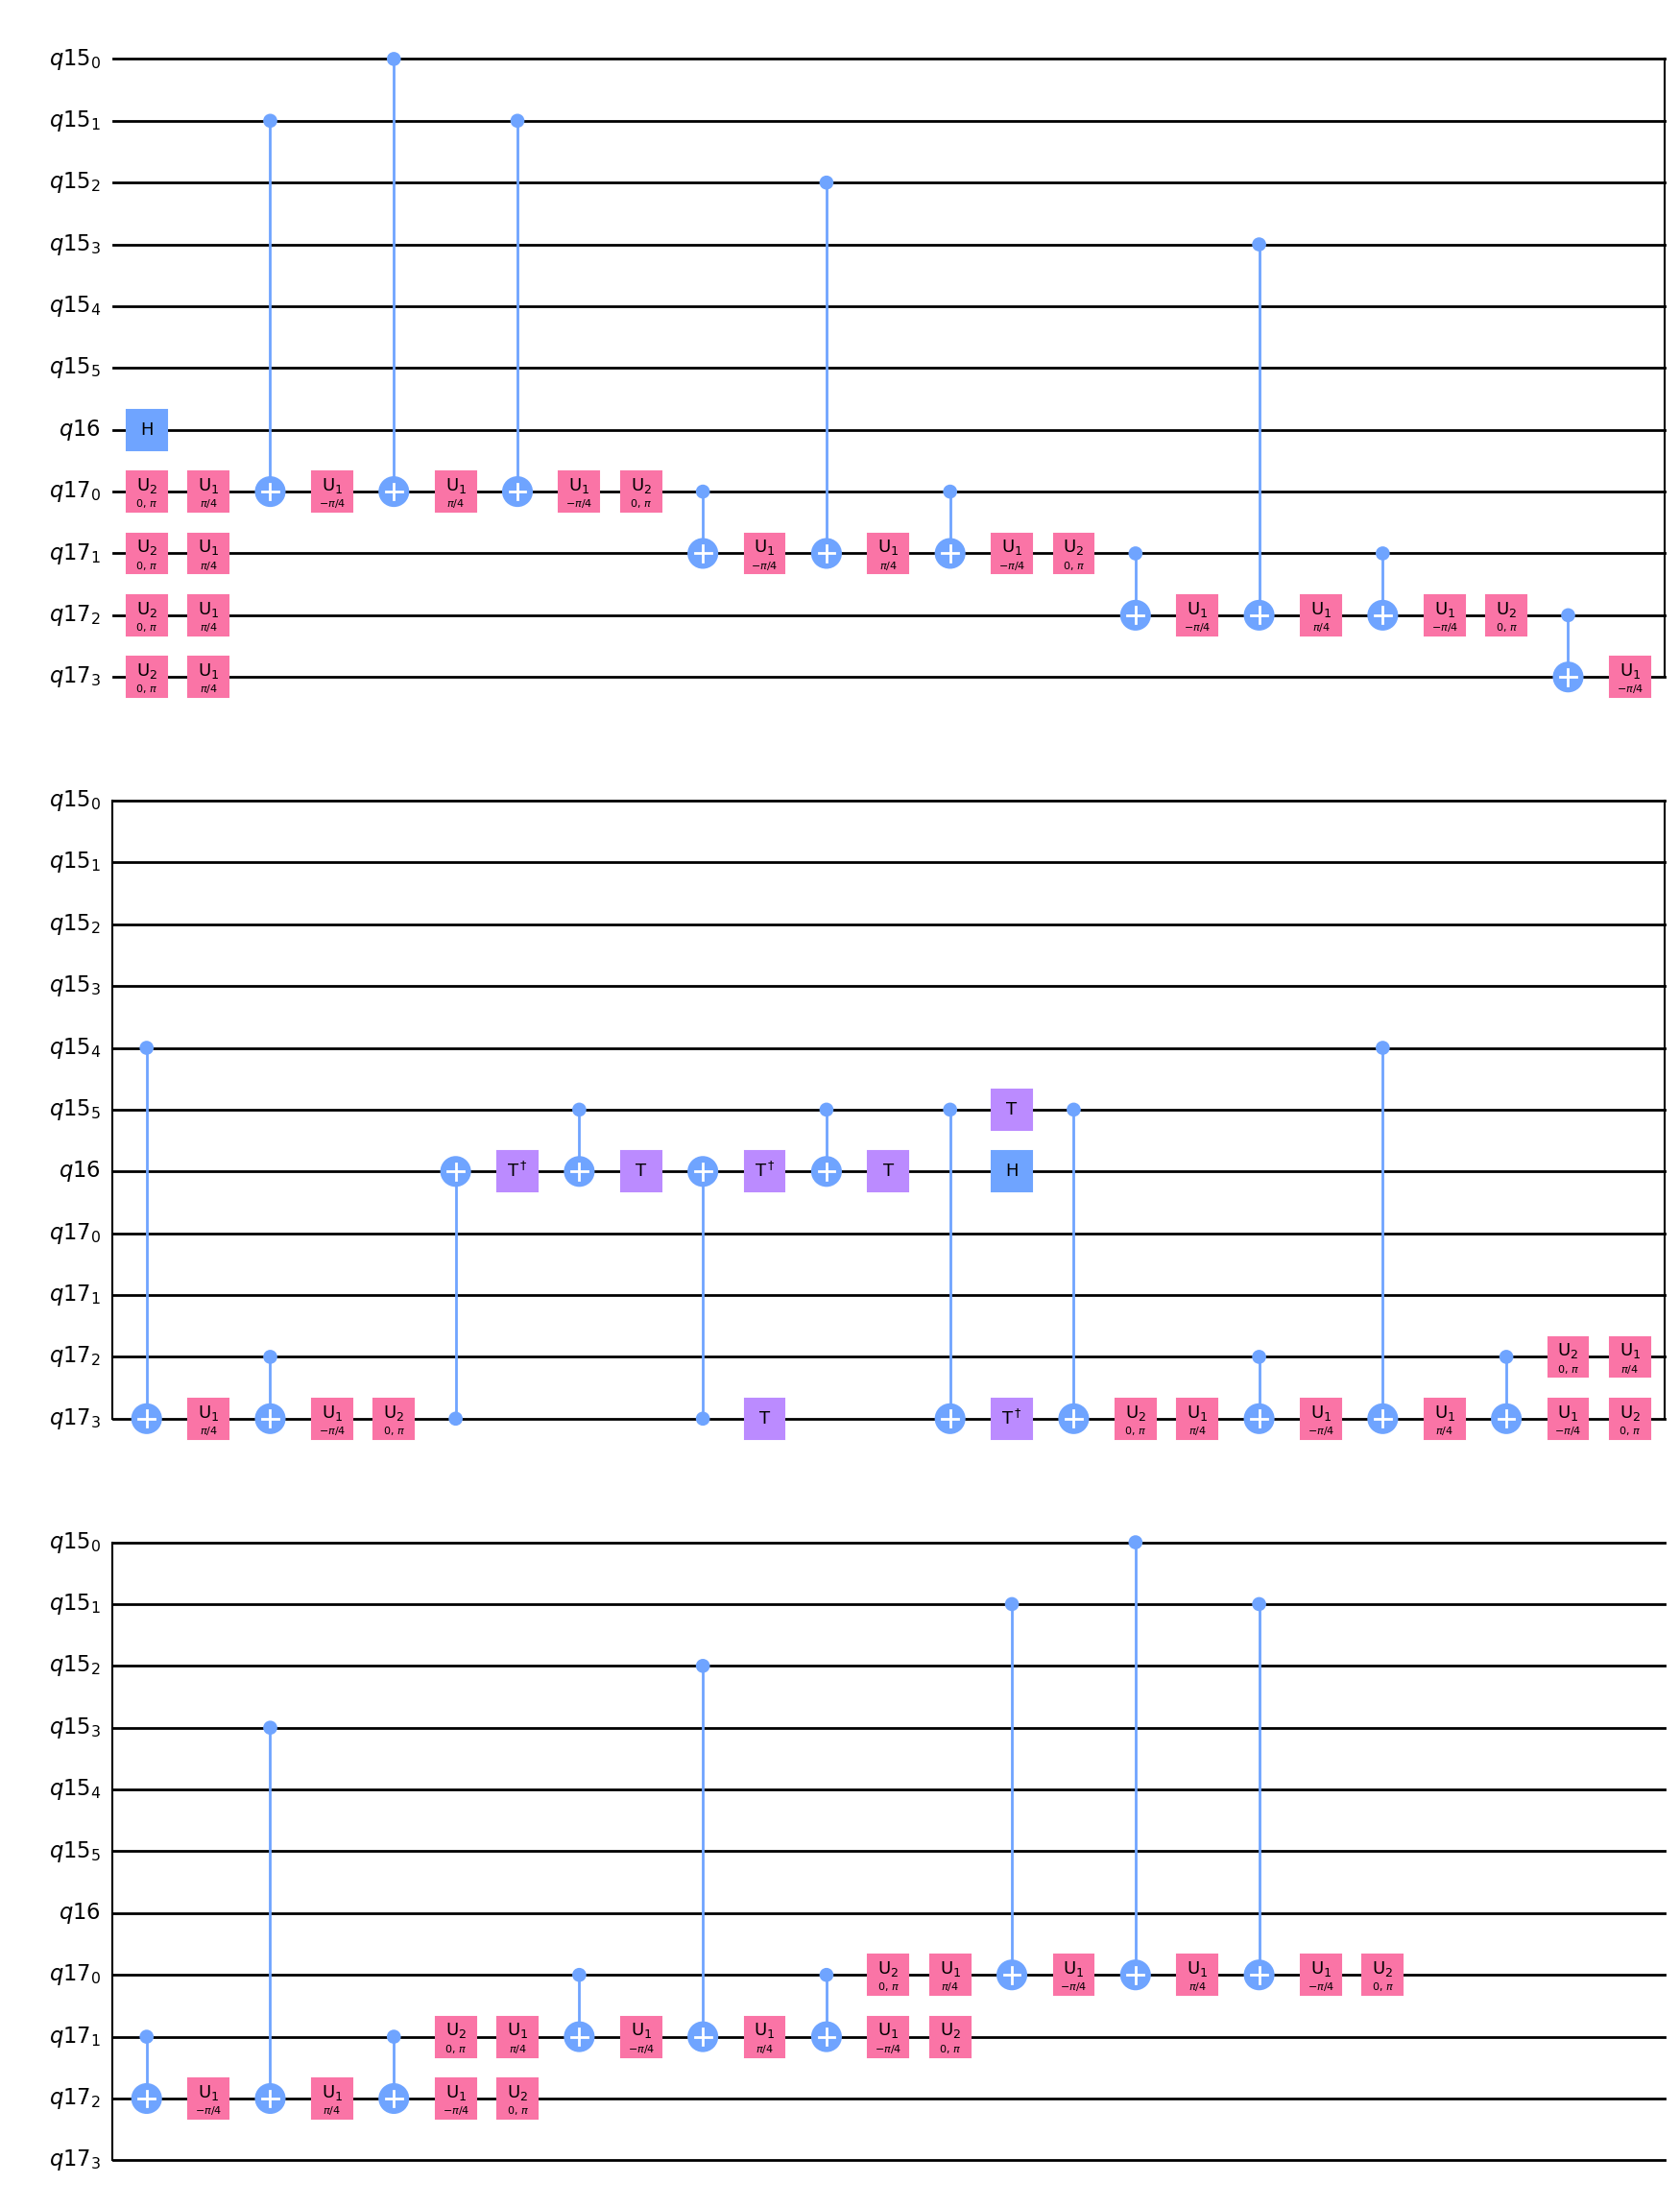

In [8]:
control = QuantumRegister(6)
target = QuantumRegister(1)
anc = QuantumRegister(4)
qc = QuantumCircuit(control, target, anc)
qc.mcx(control, target[0], anc, mode='v-chain')
qc.decompose().decompose().draw('mpl')

C:\ProgramData\anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


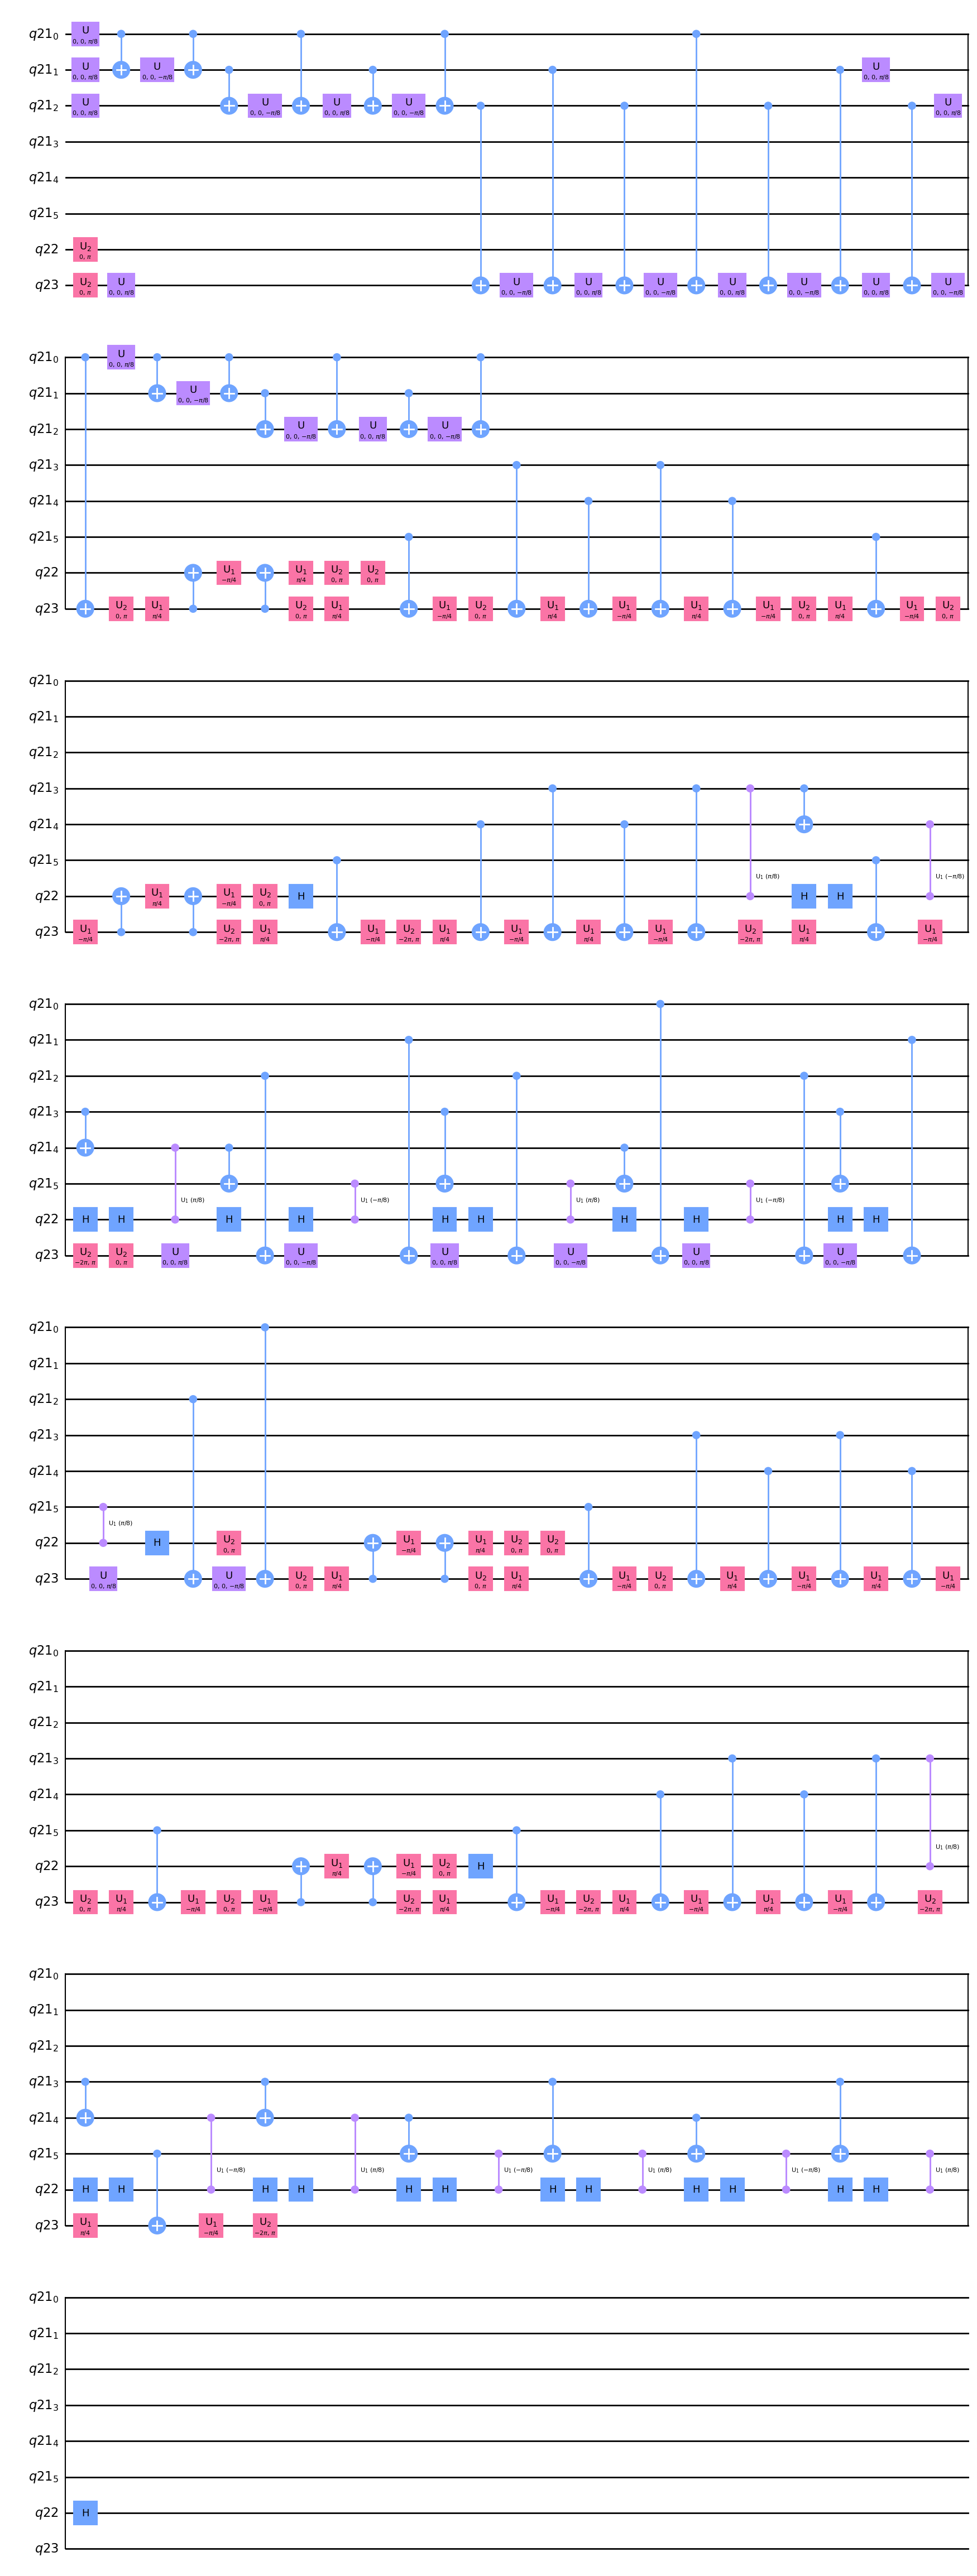

In [10]:
control = QuantumRegister(6)
target = QuantumRegister(1)
anc = QuantumRegister(1)
qc = QuantumCircuit(control, target, anc)
qc.mcx(control, target[0], anc, mode='recursion')
qc.decompose().decompose().decompose().draw('mpl')